# GAN (Generative Adversarial Networks)

En este practico vamos a estar implementando el modelo generativo [GAN (Generative Adversarial Networks)](https://arxiv.org/pdf/1406.2661)

In [1]:
import math
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
# Transformamos los datos a tensores y los normalizamos
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])

# Descargamos el dataset
dataset = datasets.FashionMNIST(root='./data', download=True, transform=transform)

# Creamos el dataloader
batch_size = 64
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Running on {device}")

100%|██████████| 26.4M/26.4M [00:02<00:00, 8.94MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 149kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.77MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.9MB/s]

Running on cuda


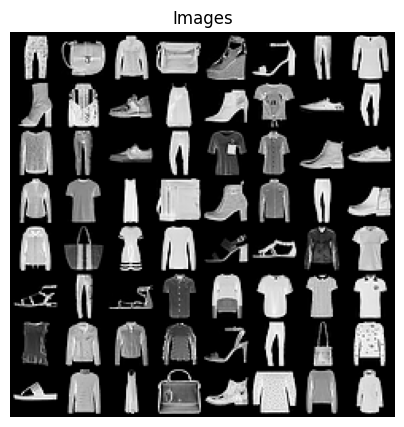

In [3]:
def show_imgs(imgs, title="Images"):
    plt.figure(figsize=(5,5))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(vutils.make_grid(imgs, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show()

real_batch = next(iter(dataloader))[0][:64]
img_shape = real_batch[0].shape
show_imgs(real_batch)

## Definimos el modelo
Las GANs (Generative Adversarial Networks) consisten en dos redes que compiten entre sí: un generador que crea datos falsos y un discriminador que trata de distinguirlos de los datos reales, mejorando así la calidad de los datos generados con el tiempo.

### Generador
Es una red neuronal que, partiendo de un espacio latente, crea datos sintéticos con el objetivo de parecerse a los datos reales.

Esta "parte" del modelo es la que nos va a servir luego para la generación.

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim, number_feature_maps, output_channels):
        super(Generator, self).__init__()
        self.latent_feature_maps = latent_dim
        self.main = nn.Sequential(
            # Tamaño entrada (bs, tamaño latente, 1, 1)
            nn.ConvTranspose2d(latent_dim, number_feature_maps * 4, 7, 1, 0, bias=False),
            nn.BatchNorm2d(number_feature_maps * 4),
            nn.ReLU(True),
            # Tamaño (bs, number_feature_maps*4, 7 , 7)
            nn.ConvTranspose2d(number_feature_maps * 4, number_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(number_feature_maps * 2),
            nn.ReLU(True),
            # Tamaño (bs, number_feature_maps*2, 14 , 14)
            nn.ConvTranspose2d(number_feature_maps * 2, number_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(number_feature_maps),
            nn.ReLU(True),
            # Tamaño (bs, number_feature_maps, 28 , 28)
            nn.ConvTranspose2d(number_feature_maps, output_channels, 3, 1, 1, bias=False),
            nn.Tanh(),
            # Tamaño salida (bs, 1, 28 , 28)
        )

    def forward(self, input):
        result = self.main(input)
        return result

### Discriminador

Es una red neuronal que clasifica los datos como reales o generados. Su tarea es distinguir entre los datos reales y los falsos producidos por el generador, ayudando así a mejorar la calidad de ambos.

In [5]:
class Discriminator(nn.Module):
    def __init__(self, input_channels, number_feature_maps, output_dim):
        super(Discriminator, self).__init__()
        self.conv_layers = nn.Sequential(
            # Tamaño entrada (bs, 1, 28, 28)
            nn.Conv2d(input_channels, number_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(number_feature_maps),
            nn.LeakyReLU(0.2, inplace=True),
            # Tamaño (bs, number_feature_maps, 14, 14)
            nn.Conv2d(number_feature_maps, number_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(number_feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Tamaño (bs, number_feature_maps*2, 7, 7)
            nn.Conv2d(number_feature_maps * 2, number_feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(number_feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Tamaño (bs, number_feature_maps*4, 4, 4)
        )

        self.fully_connected = nn.Sequential(
            nn.Flatten(1),
            # Tamaño (bs, 3*3*number_feature_maps*4)
            nn.Linear(3*3*number_feature_maps*4, output_dim),
            nn.Sigmoid()
        )

    def forward(self, input):
        res = self.conv_layers(input)
        res = self.fully_connected(res)
        return res

## Definición de hyperparámetros y creación del modelo.

1. **Learning rates balanceados**: Ambos optimizadores usan `lr=0.0002` para mantener equilibrio
2. **Orden de entrenamiento**: Discriminador primero, generador después (estándar en GANs)
3. **Label smoothing**: Etiquetas suavizadas (0.9 en vez de 1.0, 0.1 en vez de 0.0) para evitar sobreconfianza
4. **Beta momentum**: Valores `betas=(0.5, 0.999)` en Adam para mejor estabilidad en GANs

Estos cambios previenen que el discriminador se vuelva demasiado fuerte o demasiado débil, manteniendo un equilibrio saludable durante todo el entrenamiento.

In [6]:
# Definimos hyperparámetros
latent_dim = 100
discriminator_lr = 0.0002
generator_lr = 0.0002  # Igualado para balance en el entrenamiento
n_epochs = 12

# Creamos el generador y el discriminador
generator = Generator(latent_dim=latent_dim, number_feature_maps=64, output_channels=1).to(device)
discriminator = Discriminator(input_channels=1, number_feature_maps=64, output_dim=1).to(device)

# Definir la función de pérdida
adversarial_loss = nn.BCELoss()

In [7]:
# Definimos la función de entrenamiento del modelo
def train(generator, discriminator, adversarial_loss, dataloader, n_epochs, device, verbose=False):
    # Creamos los dos optimizadores.
    # Recordar que estos optimizadores son distintos ya que cada uno precisa los parametros
    #  a entrenar y el discriminador y el generador se entrenan por separado.
    optimizer_G = optim.Adam(generator.parameters(), lr=generator_lr, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=discriminator_lr, betas=(0.5, 0.999))

    for epoch in tqdm(range(n_epochs)):
        for i, (imgs, _) in enumerate(dataloader):
            bs = imgs.size(0)

            # Creamos las etiquetas para el discriminador con label smoothing
            valid = torch.ones(bs, 1).to(device) * 0.9  # En vez de 1.0, usamos 0.9
            fake = torch.zeros(bs, 1).to(device) * 0.1  # En vez de 0.0, usamos 0.1

            real_imgs = imgs.to(device)

            # Creamos ruido dentro del espacio latente usando una normal
            latent_shape = (bs, latent_dim, 1, 1)
            z = torch.randn(latent_shape).to(device)

            # Entrenamos el discriminador primero
            optimizer_D.zero_grad()

            # Pérdida con imágenes reales
            real_loss = adversarial_loss(discriminator(real_imgs), valid)

            # Pérdida con imágenes falsas
            gen_imgs = generator(z)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)

            # Pérdida total del discriminador
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            # Entrenamos el generador
            optimizer_G.zero_grad()

            # El generador quiere que el discriminador clasifique las imágenes falsas como reales
            # Por eso usamos la etiqueta "valid" (1.0)
            g_loss = adversarial_loss(discriminator(gen_imgs), torch.ones(bs, 1).to(device))
            g_loss.backward()
            optimizer_G.step()

            if verbose: print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

        if epoch % 4 == 0:
            show_imgs(gen_imgs.data[:32], title=f"Epoch {epoch}")


## Entrenamiento del modelo

  0%|          | 0/12 [00:00<?, ?it/s]

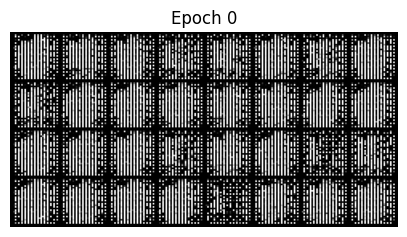

 33%|███▎      | 4/12 [01:21<02:41, 20.20s/it]

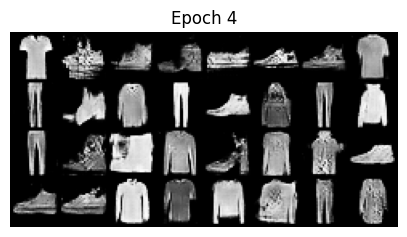

 67%|██████▋   | 8/12 [02:40<01:18, 19.70s/it]

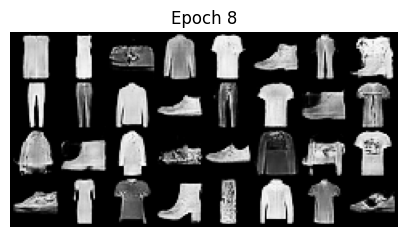

100%|██████████| 12/12 [03:59<00:00, 19.95s/it]


In [8]:
# Comenzamos el entrenamiento del modelo!
train(generator, discriminator, adversarial_loss, dataloader, n_epochs, device)

## Generación de datos

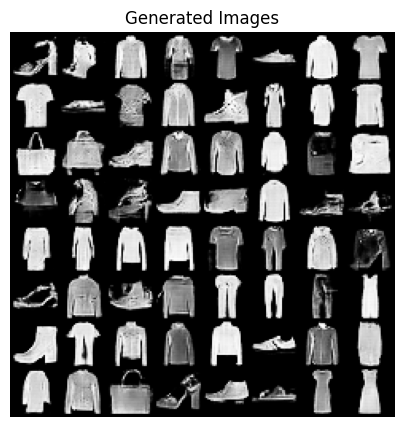

In [9]:
def generate(generator, num_imgs=32):
    # Creamos un tensor de ruido dentro del espacio latente
    z = torch.randn(num_imgs, latent_dim, 1, 1).to(device)
    # Hacemos el forward pass del generador
    gen_imgs = generator(z)
    return gen_imgs

imgs = generate(generator, num_imgs=64)
show_imgs(imgs, title="Generated Images")

## Ejercicios:

1. Complete el codigo faltante y entrene una GAN que genere imágenes de Fashion MNIST.
2. Responda las siguientes preguntas:
    - ¿En qué afecta el tamaño del espacio latente?
    - ¿Por qué entrenamos al discriminador y al generador alternativamente?
    - ¿Qué tamaño tiene la salida del discriminador y por qué? ¿Y el generador?
    - ¿Qué tipo de activación final se usa en el discriminador y por qué?
    - ¿Cuál es el propósito de la competencia entre el generador y el discriminador en las GANs? Explica cómo esto contribuye a la mejora del modelo.
    - Entrene una GAN que genere imágenes del dataset [SVHN (street view house number)](http://ufldl.stanford.edu/housenumbers/).
    - Comente los resultados obtenidos con este dataset.

### 1. ¿En qué afecta el tamaño del espacio latente?

El tamaño del espacio latente afecta la **capacidad de representación** y la **diversidad** de las imágenes generadas:

- **Espacio latente chico** : Limita la variabilidad de las imágenes generadas. Puede producir menos diversidad pero imágenes más consistentes.
- **Espacio latente grande**: Permite mayor diversidad y captura más detalles, pero puede ser más difícil de entrenar y requerir más datos.

Un espacio latente más grande también implica más parámetros en la primera capa del generador, lo que aumenta la complejidad del modelo.
Hay que buscar un tamaño optimo de espacio latente que permita generar imágenes consistentes y lo mas diversas posibles mientras sea posible de entrenar.

### 2. ¿Por qué entrenamos al discriminador y al generador alternativamente?

El entrenamiento alternado es fundamental para las GANs. Si entrenamos solo uno de los dos, el otro se vuelve inútil. El discriminador perfecto siempre detectaría fakes, y el generador nunca mejoraría.
Cada red mejora en respuesta a las mejoras de la otra, creando un proceso de mejora continua.

El proceso es como un falsificador (generador) y un detective (discriminador) que se desafían mutuamente hasta que el falsificador produce obras indistinguibles de las originales.

### 3. ¿Qué tamaño tiene la salida del discriminador y por qué? ¿Y el generador?

**Discriminador:**
- **Tamaño de salida**: `(batch_size, 1)` - un único valor escalar por imagen que corresponde a la clasificacion de las imágenes de entrada (entre 0 y 1 por la funcion de activación sigmoide)

**Generador:**
- **Tamaño de salida**: `(batch_size, 1, 28, 28)` en este caso ya que las imágenes de salida seran del mismo tamaño que las de entrada.

### 4. ¿Qué tipo de activación final se usa en el discriminador y por qué?

**Sigmoid** es la activación final del discriminador porque el discriminador realiza clasificación binaria asignando una probabilidad entre 0 y 1 de que la imagen pertenezca a los datos reales.


### 5. ¿Cuál es el propósito de la competencia entre el generador y el discriminador en las GANs? Explica cómo esto contribuye a la mejora del modelo.

El proposito es generar un ciclo en el cual cada modelo se vaya adaptando a las mejoras del otro, logrando que ambas contribuyan a la mejora general de la GAN.

**Ciclo de mejora:**

1. **Discriminador mejora** → Aprende a distinguir mejor entre imágenes reales y falsas
2. **Generador recibe mejor feedback** → Los gradientes del discriminador más entrenado son más informativos
3. **Generador mejora** → Crea imágenes más realistas para "engañar" al discriminador
4. **Discriminador se adapta** → Debe mejorar nuevamente para detectar las nuevas fakes

Esto permite a las GANs generar datos altamente realistas sin necesidad de definir explícitamente qué hace "buena" una imagen.

Estas imágenes son de (3, 32, 32). Debe crear un nuevo generador y dicriminador para ajustarse a estas nuevas dimensiones.

Image size: torch.Size([3, 32, 32])


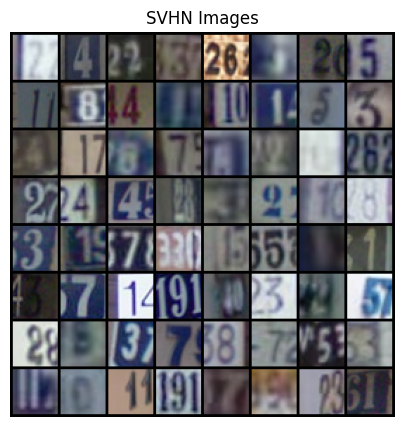

In [15]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0, 1)
    ])

dataset = datasets.SVHN(root='./data', download=True, transform=transform)
print(f"Image size: {dataset[0][0].shape}")

batch_size = 64
dataloader_2 = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
real_batch = next(iter(dataloader_2))[0]
img_shape = real_batch[0].shape
show_imgs(real_batch, "SVHN Images")

---
# Implementación para SVHN Dataset


### Generador para SVHN (3x32x32)

In [11]:
class Generator_SVHN(nn.Module):
    def __init__(self, latent_dim, number_feature_maps, output_channels):
        super(Generator_SVHN, self).__init__()
        self.latent_feature_maps = latent_dim
        self.main = nn.Sequential(
            # Tamaño entrada (bs, latent_dim, 1, 1)
            nn.ConvTranspose2d(latent_dim, number_feature_maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(number_feature_maps * 8),
            nn.ReLU(True),
            # Tamaño (bs, number_feature_maps*8, 4, 4)
            nn.ConvTranspose2d(number_feature_maps * 8, number_feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(number_feature_maps * 4),
            nn.ReLU(True),
            # Tamaño (bs, number_feature_maps*4, 8, 8)
            nn.ConvTranspose2d(number_feature_maps * 4, number_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(number_feature_maps * 2),
            nn.ReLU(True),
            # Tamaño (bs, number_feature_maps*2, 16, 16)
            nn.ConvTranspose2d(number_feature_maps * 2, number_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(number_feature_maps),
            nn.ReLU(True),
            # Tamaño (bs, number_feature_maps, 32, 32)
            nn.ConvTranspose2d(number_feature_maps, output_channels, 3, 1, 1, bias=False),
            nn.Tanh(),
            # Tamaño salida (bs, 3, 32, 32)
        )

    def forward(self, input):
        result = self.main(input)
        return result

### Discriminador para SVHN (3x32x32)

In [12]:
class Discriminator_SVHN(nn.Module):
    def __init__(self, input_channels, number_feature_maps, output_dim):
        super(Discriminator_SVHN, self).__init__()
        self.conv_layers = nn.Sequential(
            # Tamaño entrada (bs, 3, 32, 32)
            nn.Conv2d(input_channels, number_feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Tamaño (bs, number_feature_maps, 16, 16)
            nn.Conv2d(number_feature_maps, number_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(number_feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Tamaño (bs, number_feature_maps*2, 8, 8)
            nn.Conv2d(number_feature_maps * 2, number_feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(number_feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Tamaño (bs, number_feature_maps*4, 4, 4)
            nn.Conv2d(number_feature_maps * 4, number_feature_maps * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(number_feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Tamaño (bs, number_feature_maps*8, 2, 2)
        )

        self.fully_connected = nn.Sequential(
            nn.Flatten(1),
            # Tamaño (bs, 2*2*number_feature_maps*8)
            nn.Linear(2*2*number_feature_maps*8, output_dim),
            nn.Sigmoid()
        )

    def forward(self, input):
        res = self.conv_layers(input)
        res = self.fully_connected(res)
        return res

### Instanciamos el generador y discriminador

In [13]:
generador_2 = Generator_SVHN(latent_dim=latent_dim, number_feature_maps=64, output_channels=3).to(device)
discriminador_2 = Discriminator_SVHN(input_channels=3, number_feature_maps=64, output_dim=1).to(device)

### Entrenamos la GAN

  0%|          | 0/12 [00:00<?, ?it/s]

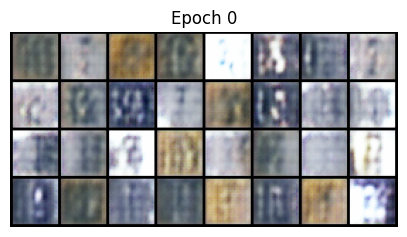

 33%|███▎      | 4/12 [01:55<03:51, 28.88s/it]

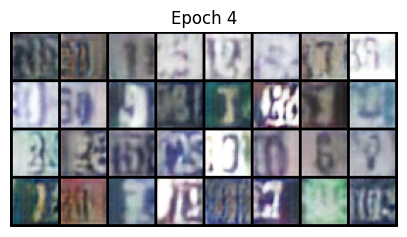

 67%|██████▋   | 8/12 [03:50<01:54, 28.72s/it]

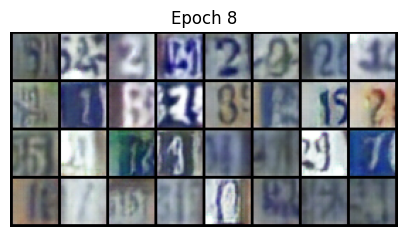

100%|██████████| 12/12 [05:45<00:00, 28.79s/it]


In [16]:
# Comenzamos el entrenamiento del modelo!
train(generador_2, discriminador_2, adversarial_loss, dataloader_2, n_epochs, device)

## Generamos imágenes SVHN



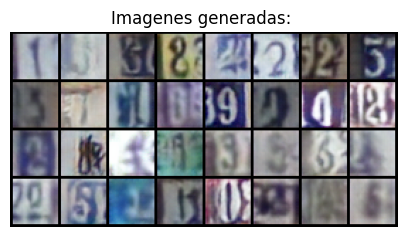

In [19]:
show_imgs(generate(generador_2,32),"Imagenes generadas: ")
